#Visualizing and understanding ConvNets (part 1)
In this Lab we will be experimenting with techniques for visualizing and understanding ConvNets.

The first part (part 1) is about simple visualization techniques:

- Visualizing layer activations
- Visualizing filters
- Inspecting fully connected layers
- Feature visualizing using dimensionality reduction

Much of part 1 will be a recap of [Lab 2](https://github.com/aivclab/dlcourse/blob/master/Lab2_FeatureExtractionAndTransferLearning.ipynb
), so you can skip it or save it for later and start with part 2 and part 3.

**Before we start - remember to set runtime to GPU**

**NOTE:** In case you have trouble running Keras/TensorFlow in Colab, try one of the following:

In [0]:
# Try this
#!pip install --upgrade tensorflow==1.8.0

# ... or this
%tensorflow_version 1.x

# Check TensorFlow version
#import tensorflow as tf
#print(tf.__version__)

##Mount your Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Download a test image
Lets download an image to work on:

In [0]:
import urllib.request

url = "https://github.com/aivclab/dlcourse/raw/master/data/cat.jpg"
urllib.request.urlretrieve(url,'/content/gdrive/My Drive/cat.jpg')

# Check that the file is in your Drive
!ls "/content/gdrive/My Drive/cat.jpg"

'/content/gdrive/My Drive/cat.jpg'


Display

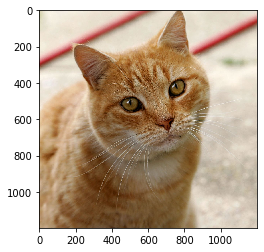

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image using OpenCV
img_path = '/content/gdrive/My Drive/cat.jpg'
img = cv2.imread(img_path) #<your code goes here>
b,g,r = cv2.split(img)
rgb = cv2.merge((r,g,b))
plt.imshow(rgb)

## Set up VGG16
First, let's download and instantiate a pre-trained VGG16 network including the top layers:

In [0]:
from keras.applications import VGG16
from keras.utils import plot_model

vgg16_full = VGG16(weights='imagenet',
                      include_top=True,
                      input_shape=(224, 224, 3))

plot_model(vgg16_full,show_shapes=True,show_layer_names=True)

Preprocess the image (in the case of VGG16, Keras subtracts the channel-wise mean [103.939, 116.779, 123.68]): 

In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_preprocessed = preprocess_input(img_data.copy())

# Range before preprocessing
print('np.min(img_data)',np.min(img_data))
print('np.max(img_data)',np.max(img_data))

# Range after preprocessing
print('np.min(img_preprocessed)',np.min(img_preprocessed))
print('np.max(img_preprocessed)',np.max(img_preprocessed))

# Shapes
print('img_preprocessed.shape',img_preprocessed.shape)

plt.figure(figsize=(8,10))
plt.subplot(311); plt.imshow(img_data.squeeze()/255); plt.title('Before preprocessing');
plt.subplot(312); plt.imshow(img_preprocessed.squeeze()/255); plt.title('After preprocessing (positive values only)');
plt.subplot(313); plt.imshow(-img_preprocessed.squeeze()/255); plt.title('After preprocessing (negative values only)');

## Classifiy test image

In [0]:
from keras.applications.imagenet_utils import decode_predictions

predictions = vgg16_full.predict(img_preprocessed)
print('predictions.shape',predictions.shape)  

labels = decode_predictions(predictions)
[print(name,prob) for code, name, prob in labels[0]]

###Task
1. Assuming that the correct class is `tiger_cat`, what is the class index (i.e., the index of `predictions` that correspond to `tiger_cat`)?

In [0]:
class_index = ???

## Visualizing layer activations
Show stats about convolution layers:

In [0]:
for i, layer in enumerate(vgg16_full.layers):
  
  # check for convolutional layer
  layer_type = layer.__class__.__name__
  
  if 'Conv' not in layer_type:
    continue
  
  # get filter weights
  layer_name = layer.name
  input_shape = layer.input_shape
  output_shape = layer.output.shape
  filter_shape = layer.get_weights()[0].shape
  
  print(f"Layer {i} has name {layer_name}, input shape {input_shape}, filter shape {filter_shape}, and output shape {output_shape}")

Get filters of `block1_conv1` and display them:

In [0]:
layer = vgg16_full.get_layer('block1_conv1')
filters = layer.get_weights()
plt.figure(figsize=(8,8))
for i in range(64):
  f = filters[0][:,:,:,i]
  
  # Normalize to range 0 ... 1
  f -= f.min()
  f /= f.max()
  
  plt.subplot(8,8,i+1)
  plt.imshow(f)
  plt.title(str(i))

###Questions
1. When displaying filters, what should you be looking for?
2. How would you visualize the filters of the last conv layer?

##Visualizing layer activations
Let's visualize the activations of the second conv layer in the first block:

In [0]:
from keras import Model
dummy_model = Model(inputs=vgg16_full.input, outputs=vgg16_full.get_layer('block1_conv2').output) # See conv_base.summary() for complete list of layer names
out = dummy_model.predict(img_preprocessed)
out = out.squeeze()

plt.figure(figsize=(16,16))
for i in range(64):
  f = out[:,:,i]
  plt.subplot(8,8,i+1)
  plt.imshow(f)
  plt.title("{0:.2f}".format(f.min()) + "/" + "{0:.2f}".format(f.max()))

###Questions
1. What features are detected by this layer?
2. Can you say something about which features are detected by the last convoution layer (block 5 conv 2)?

##Download more test images
Download csv files with URLs:

In [0]:
from pathlib import Path

root = '/content/gdrive/My Drive/' # Don't change this
data_dirname = 'data' # Change as you like
p = Path(root + data_dirname)
p.mkdir(exist_ok=True)

classes = ['bird','cat','cows','dog','horse','mouse','pig','sheep']
for idx, name in enumerate(classes):
  print(name)
  folder = name
  file = name + '.csv'
  url = 'https://raw.githubusercontent.com/klaverhenrik/klaverhenrik.github.io/master/transferlearning/examples/' + name + '.csv'
  urllib.request.urlretrieve(url,p/file)

Download images (this may take a while - in the meantime you could start solving the last task at the very bottom: implement saliency by occlusion):

In [0]:
from fastai.vision.data import download_images
from fastai.vision.data import verify_images

max_pics = 400
for idx, name in enumerate(classes):
  print(name)
  folder = name
  file = name + '.csv'
  dest = p/folder
  dest.mkdir(parents=True, exist_ok=True)
  download_images(p/file, dest, max_pics=max_pics)

Prune of remove non-image files:

In [0]:
for c in classes:
    print(c)
    verify_images(p/c, delete=True, max_size=500)

Make data generator that runs through all images:

In [0]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32
datagen = ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
generator = datagen.flow_from_directory(str(p), # this is where you specify the path to the main data folder
                                        target_size=(224,224),
                                        color_mode='rgb',
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=True)

Found 2884 images belonging to 8 classes.


Verify that generator classes and your classes are in the same order:

In [0]:
print(generator.class_indices)
print(classes)

{'bird': 0, 'cat': 1, 'cows': 2, 'dog': 3, 'horse': 4, 'mouse': 5, 'pig': 6, 'sheep': 7}
['bird', 'cat', 'cows', 'dog', 'horse', 'mouse', 'pig', 'sheep']


##Inspecting fully connected layers
Here we are slightly modify the model. How (in what way)?


In [0]:
from keras import activations
from keras.models import load_model

# Copy the model
model = Model(inputs=vgg16_full.input, outputs=vgg16_full.get_layer('predictions').output)

# What is happenning here?
model.layers[-1].activation = activations.linear
model.save('dummy')
model = load_model('dummy')

scores = model.predict(img_preprocessed)
print(scores)

Extract 1000-dimensional feature vectors from last FC layer and run K Nearest Neighbors:

In [0]:
#https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py
from sklearn import neighbors

# Function returns pairs of observations:
# - features_raw are the raw images
# - features_net are the network feature vectors
def extract_features(generator,batch_size,num_batches):
    sample_count = batch_size * num_batches
    features_raw = np.zeros(shape=(sample_count, 224*224*3))
    features_net = np.zeros(shape=(sample_count, 1000))
    labels = np.zeros(shape=(sample_count))
    i = 0
    for inputs_batch, labels_batch in generator:
        print(i)
        features_batch = np.reshape(inputs_batch,(batch_size,224*224*3))
        features_raw[i * batch_size : (i + 1) * batch_size] = features_batch
        
        features_batch = model.predict(inputs_batch)
        features_batch = np.reshape(features_batch,(batch_size,1000))
        features_net[i * batch_size : (i + 1) * batch_size] = features_batch
        
        labels[i * batch_size : (i + 1) * batch_size] = np.argmax(labels_batch,axis=1)
        
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features_raw, features_net, labels

num_batches = 50
features_raw, features_net, labels = extract_features(generator, batch_size, num_batches)

# Train K-NN classifier on network features (features_net) with k = 10
nbrs = neighbors.NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(features_net)

Count number of exampls within each class (just a test - numbers should be fairly equal):

In [0]:
for i in range(8):
  print(i,len(np.where(labels==i)[0]))

Pick a random image and display its 10 closest neighbours:

In [0]:
# Pick test image
filelist = [x for x in (p/classes[np.random.randint(0,len(classes)-1)]).iterdir() if x.is_file()]
img_path = filelist[np.random.randint(0,len(filelist)-1)]
print(f"File path: {img_path}")

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_data = preprocess_input(img_data)

# Feed test image through network to get feature vector
X = model.predict(img_data)
X = np.reshape(X,(1,1000)) # Vectorize

# Get indicies of 10 nearest neighbours (+ distances)
distances, indices = nbrs.kneighbors(X)

# Display nearest neighbours
plt.figure()
im = (img_data[0,:,:,:]+128)/255
b,g,r = cv2.split(im)
rgb = cv2.merge((r,g,b))
plt.imshow(np.clip(rgb,0,1,out=rgb))
plt.imshow(rgb)
plt.figure(figsize=(12,6))
for i in range(10):
  plt.subplot(2,5,i+1)
  im = (np.reshape(features_raw[indices[0][i],:],(224,224,3)) + 128) / 255
  b,g,r = cv2.split(im)
  rgb = cv2.merge((r,g,b))
  plt.imshow(np.clip(rgb,0,1,out=rgb))

###Questions
Run the above code blok a few times and inspect the output.

1. What should you be looking for?
2. Are you happy with what ou see?

## Visualization using dimensionality reduction
Run t-SNE of extracted feature vectors:

In [0]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Same as above, but using neural net representation
X = features_net
y = labels
print(X.shape, y.shape)

feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['y'] = df['y'].apply(lambda i: classes[int(i)])
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

rndperm = np.random.permutation(df.shape[0])

N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("bright", len(classes)),
    data=df_subset,
    legend="full",
    alpha=0.3
)

###Questions
1. What can you say about the the topology of the learned representation?
2. Are any of the classes clearly separated from the others?
3. Which classes are likely confused more often than others?

##Implement saliency by occlusion
Implement saliency by occlusion and test it on the first cat image.

I used a window size of 48 pixels and a stride of 4 in my solution.

Here is some code to get you started:

In [0]:
img_path = '/content/gdrive/My Drive/cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_data = image.img_to_array(img)
img_data = np.expand_dims(img_data, axis=0)
img_preprocessed = preprocess_input(img_data.copy())

predictions = vgg16_full.predict(img_preprocessed)

class_index = np.argmax(predictions)
print(class_index)

prob = predictions[0,class_index]
print(prob)